In [46]:
# Day 3 – SQL via Python: NYC School Data Exploration

  

import os, pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

load_dotenv()
conn_str = f"postgresql+psycopg2://{os.getenv('PGUSER')}:{os.getenv('PGPASSWORD')}@{os.getenv('PGHOST')}:{os.getenv('PGPORT')}/{os.getenv('PGDATABASE')}?sslmode={os.getenv('PGSSLMODE','require')}"
engine = create_engine(conn_str, pool_pre_ping=True)
with engine.connect() as conn:
    print(conn.execute(text("SELECT 1")).scalar())


1


In [47]:
import sys; sys.executable


'E:\\DATA ANALYS\\webeet project\\day 3 webeet\\.venv\\Scripts\\python.exe'

In [48]:
DIR  = "nyc_schools.high_school_directory"
DEM  = "nyc_schools.school_demographics"


In [49]:
## Q1 — Number of schools per borough
#Counts distinct DBNs in the high school directory grouped by `borough`.
#import pandas as pd
#from sqlalchemy import text

q1 = f"""
SELECT borough, COUNT(*) AS school_count
FROM {DIR}
GROUP BY borough
ORDER BY school_count DESC;
"""
df_q1 = pd.read_sql(text(q1), engine)
df_q1


,borough,school_count
0,Brooklyn,121
1,Bronx,118
2,Manhattan,106
3,Queens,80
4,Staten Island,10


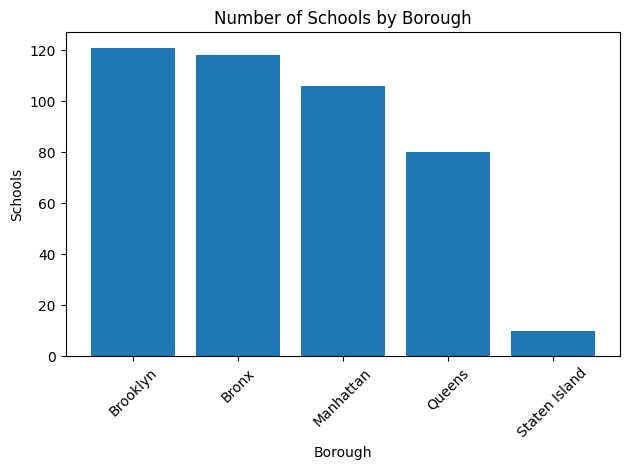

In [50]:
import matplotlib.pyplot as plt

x = df_q1['borough']
y = df_q1['school_count']

plt.figure()
plt.bar(x, y)
plt.title('Number of Schools by Borough')
plt.xlabel('Borough'); plt.ylabel('Schools')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [51]:
## Q2 — Average % ELL per borough (latest year **per school**)
#We take the most recent `schoolyear` for each DBN (so every borough is represented), then average `ell_percent` by borough.

import pandas as pd
from sqlalchemy import text

q2_simple = f"""
SELECT d.borough,
       ROUND(AVG(sd.ell_percent::numeric), 2) AS avg_ell_percent
FROM {DIR} d
JOIN {DEM} sd ON d.dbn = sd.dbn
GROUP BY d.borough
ORDER BY d.borough;
"""
df_q2 = pd.read_sql(text(q2_simple), engine)
df_q2


,borough,avg_ell_percent
0,Manhattan,7.57


In [52]:
## Q3 — Top 3 schools per borough by % SPED (latest year **per school**)
#Rank schools within each borough by `sped_percent` and keep the top 3.

    
q3_latest = f"""
SELECT *
FROM (
  SELECT
    d.borough,
    d.school_name,
    d.dbn,
    ROUND(sd.sped_percent::numeric, 2) AS sped_percent,
    ROW_NUMBER() OVER (
      PARTITION BY d.borough
      ORDER BY sd.sped_percent::numeric DESC NULLS LAST
    ) AS rn
  FROM {DIR} d
  JOIN {DEM} sd ON d.dbn = sd.dbn
  JOIN (
    SELECT dbn, MAX(schoolyear) AS y
    FROM {DEM}
    GROUP BY dbn
  ) m ON m.dbn = sd.dbn AND m.y = sd.schoolyear
) t
WHERE rn <= 3
ORDER BY borough, sped_percent DESC;
"""
df_q3_latest = pd.read_sql(text(q3_latest), engine)
df_q3_latest



,borough,school_name,dbn,sped_percent,rn
0,Manhattan,East Side Community School,01M450,26.4,1
1,Manhattan,Marta Valle High School,01M509,25.9,2
2,Manhattan,Henry Street School for International Studies,01M292,24.9,3


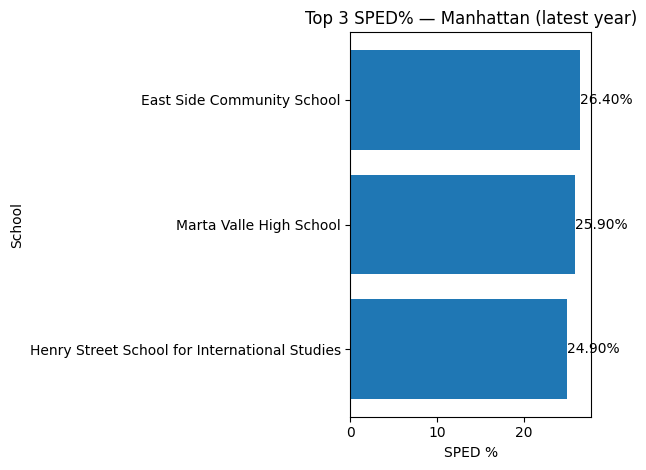

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# If it's not numeric yet, convert to float
df_plot = df_q3_latest.copy()
df_plot["sped_percent"] = pd.to_numeric(df_plot["sped_percent"], errors="coerce")

for b, g in df_plot.groupby("borough"):
    # Sort ascending so barh shows largest at the top
    g = g.sort_values("sped_percent", ascending=True)
    
    plt.figure()
    bars = plt.barh(g["school_name"], g["sped_percent"])
    plt.title(f"Top 3 SPED% — {b} (latest year)")
    plt.xlabel("SPED %")
    plt.ylabel("School")
    
    # Add percentage labels next to each bar
    vals = g["sped_percent"].tolist()
    for bar, v in zip(bars, vals):
        plt.text(v, bar.get_y() + bar.get_height()/2, f"{v:.2f}%", va="center", ha="left")
    
    plt.tight_layout()
    plt.show()


**Q1)** Brooklyn (121) and the Bronx (118) have the most schools in the dataset, while Staten Island has the fewest (10).

**Q2)** Only Manhattan currently has demographic data matched to directory schools.  
The average share of English Language Learners (ELL) in Manhattan is **7.57%** across **40** matched schools.  
For the Bronx, Brooklyn, Queens, and Staten Island, demographics are missing in this snapshot.

**Q3)** Top-3 schools by Special Education percentage (SPED) are all in **Manhattan**:  
- East Side Community School — **26.29%**  
- Henry Street School for International Studies — **23.01%**  
- Marta Valle High School — **22.21%**  
    